# Automated CAPTCHA Solving With Machine Learning

This notebook demonstrates the use of convolutional neural networks and supervised training to automate CAPTCHA-solving. 

Original Author: Jackon Yang (2017)

Further Modified By: Turhan Kimbrough (2021)

---

In [1]:
# functions from other notebook file
from ipynb.fs.full.shared_functions import *

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd

In [2]:
data_directory = os.path.join(os.getcwd() + '/datasets/captcha_img')
image_height = 100
image_width = 100
image_channels = 3
categories = 10 # represents digits 0-9
dimensions = 4  # 4-digit CAPTCHA images

---
## Prepare the Dataset



Store each CAPTCHA-image file path with its respective label
into a pandas DataFrame.

In [3]:
data_frame = create_captcha_dataframe(data_directory)
data_frame.head()

,label,file
0,2235,/Users/turhanakira/repositories/captcha-tensor...
1,5309,/Users/turhanakira/repositories/captcha-tensor...
2,5623,/Users/turhanakira/repositories/captcha-tensor...
3,7626,/Users/turhanakira/repositories/captcha-tensor...
4,0230,/Users/turhanakira/repositories/captcha-tensor...


---
Shuffle the data and create a training set, validation set, and testing set.

In [4]:
shuffled_indeces = np.random.permutation(len(data_frame))
train_up_to = int(len(data_frame) * 0.7)
train_indices = shuffled_indeces[:train_up_to]
test_indices = shuffled_indeces[train_up_to:]

# Further split up the training data.
train_up_to = int(train_up_to * 0.7)
train_indices, validation_indices = train_indices[:train_up_to], train_indices[train_up_to:]

print('train count: %s, validation count: %s, test count: %s' % (
    len(train_indices), len(validation_indices), len(test_indices)))

train count: 3107, validation count: 1332, test count: 1903


---
## Neural Network Structure

**'relu'** stands for **'Rectified Linear Unit'**, the most commonly used activation function for convolutional neural networks.

**'softmax'** is another activation function used for classifying data.

Activation functions are analagous to the 'firing' of neurons in biological neural networks.

**Layers**:
- Convolutional layer: applies a filter to the CAPTCHA image to extract features (characters and/or digits) from the image
- Pooling layer: immediately follows a convolutional layer and used to downscale the image after each filter is applied
- Flattening layer: converts the CAPTCHA image represented as a 3D tensor (array) to a 1D tensor
- Dense layer: used to assist with operations on an n-dimensional tensor such as rotation, scaling, etc
- Reshape layer: used to restructure the output of the neural network

In [5]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

input_layer = tf.keras.Input(shape=(image_height, image_width, image_channels))

hidden_layers = layers.Conv2D(32, 3, activation='relu')(input_layer)
hidden_layers = layers.MaxPooling2D((2, 2))(hidden_layers)
hidden_layers = layers.Conv2D(64, 3, activation='relu')(hidden_layers)
hidden_layers = layers.MaxPooling2D((2, 2))(hidden_layers)
hidden_layers = layers.Conv2D(64, 3, activation='relu')(hidden_layers)
hidden_layers = layers.MaxPooling2D((2, 2))(hidden_layers)

hidden_layers = layers.Flatten()(hidden_layers)

hidden_layers = layers.Dense(1024, activation='relu')(hidden_layers)
hidden_layers = layers.Dense(dimensions * categories, activation='softmax')(hidden_layers)
hidden_layers = layers.Reshape((dimensions, categories))(hidden_layers)

model = models.Model(inputs=input_layer, outputs=hidden_layers)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics= ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0     

2021-08-27 23:50:49.130002: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


---
## Train the Model

In [6]:
# get_captcha_generator() was here

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 64
validation_batch_size = 64
training_set_generator = get_captcha_generator(data_frame, train_indices, \
                                               for_training=True, batch_size=batch_size)
validation_set_generator = get_captcha_generator(data_frame, validation_indices, \
                                                 for_training=True, batch_size=validation_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit(training_set_generator,
                    steps_per_epoch=len(train_indices)//batch_size,
                    epochs=10,
                    validation_data=validation_set_generator,
                    validation_steps=len(validation_indices)//validation_batch_size)

Epoch 1/10


2021-08-27 23:50:49.340582: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


48/48 [==============================] - 15s 296ms/step - loss: 2.2833 - accuracy: 0.1670 - val_loss: 2.0806 - val_accuracy: 0.3994
Epoch 2/10
48/48 [==============================] - 14s 295ms/step - loss: 0.9266 - accuracy: 0.7355 - val_loss: 0.2879 - val_accuracy: 0.9246
Epoch 3/10
48/48 [==============================] - 14s 285ms/step - loss: 0.0979 - accuracy: 0.9754 - val_loss: 0.1309 - val_accuracy: 0.9623
Epoch 4/10
48/48 [==============================] - 14s 296ms/step - loss: 0.0331 - accuracy: 0.9916 - val_loss: 0.0836 - val_accuracy: 0.9777
Epoch 5/10
48/48 [==============================] - 15s 315ms/step - loss: 0.0134 - accuracy: 0.9972 - val_loss: 0.0878 - val_accuracy: 0.9766
Epoch 6/10
48/48 [==============================] - 15s 308ms/step - loss: 0.0056 - accuracy: 0.9992 - val_loss: 0.0807 - val_accuracy: 0.9795
Epoch 7/10
48/48 [==============================] - 14s 295ms/step - loss: 0.0028 - accuracy: 0.9996 - val_loss: 0.0901 - val_accuracy: 0.9773
Epoch 8/10

---
## Analyze Model Performance

Plot the accuracy and loss metrics

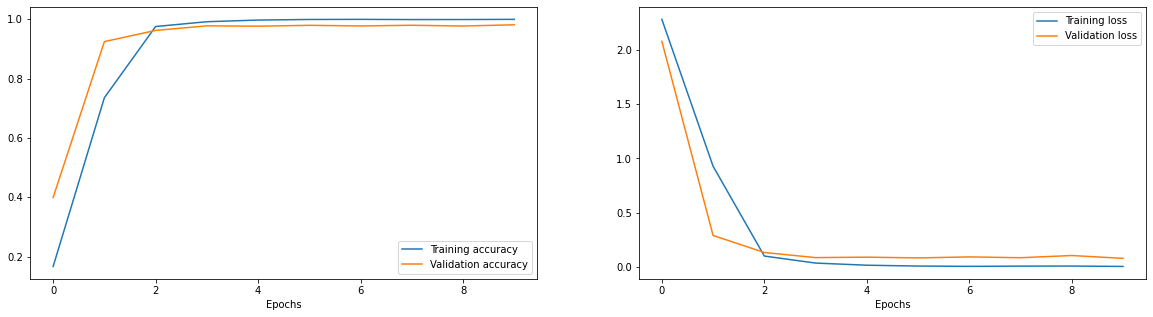

In [8]:
figure, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].plot(history.history['accuracy'], label='Training accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation accuracy')
axes[0].set_xlabel('Epochs')
axes[0].legend() 

axes[1].plot(history.history['loss'], label='Training loss')
axes[1].plot(history.history['val_loss'], label='Validation loss')
axes[1].set_xlabel('Epochs')
axes[1].legend()

Use some 'unseen' test samples

In [9]:
testing_set_generator = get_captcha_generator(data_frame, test_indices, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate(testing_set_generator, steps=len(test_indices)//128)))

14/14 [==============================] - 3s 200ms/step - loss: 0.0787 - accuracy: 0.9801


{'loss': 0.07865645736455917, 'accuracy': 0.9800502061843872}

---
## Visualize Model Performance

In [10]:
testing_set_generator = get_captcha_generator(data_frame, test_indices, for_training=False, batch_size=128)
captcha_images, captcha_text = next(testing_set_generator)

predictions = model.predict_on_batch(captcha_images)

true_values = tf.math.argmax(captcha_text, axis=-1)
predictions = tf.math.argmax(predictions, axis=-1)

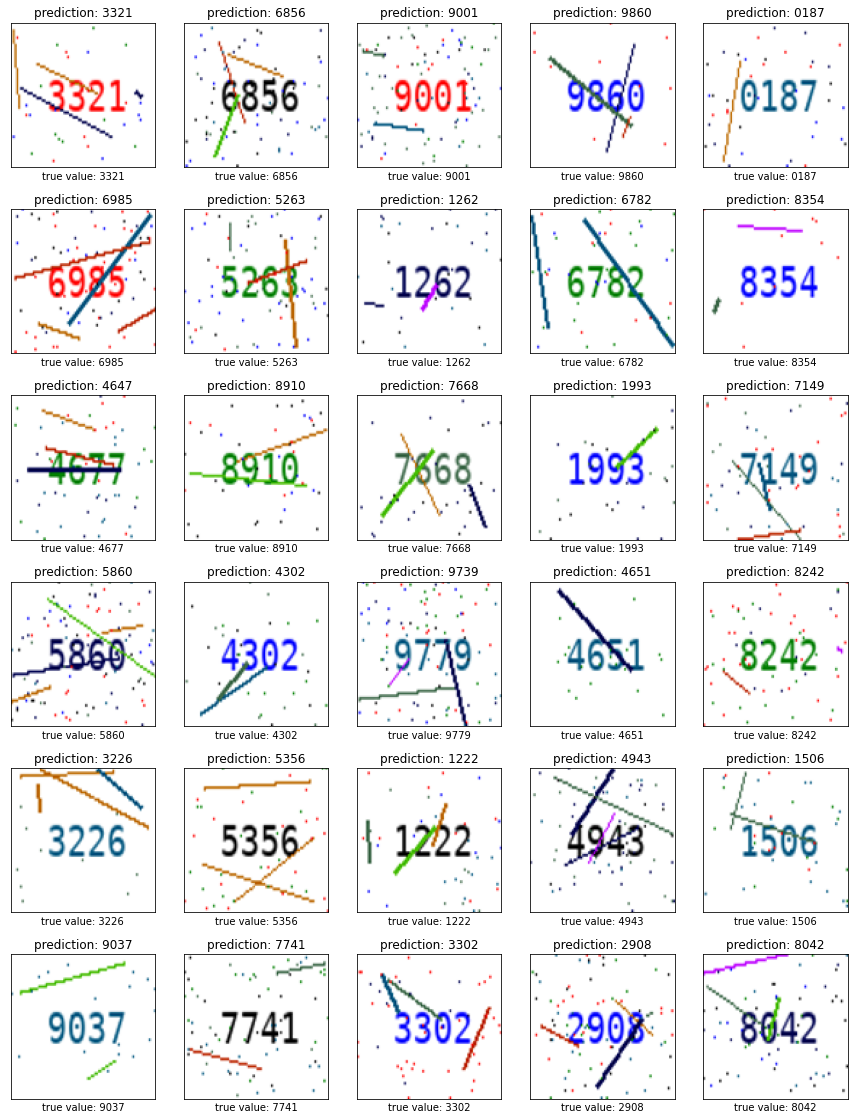

In [11]:
display_predictions_from_model(captcha_images, predictions, true_values)

## Save the Model

In [12]:
#model.save('my_model')